<a href="https://colab.research.google.com/github/prikmm/MLprojects/blob/main/LunarLander_v2_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym
!pip install tf-agents
!pip install 'gym[atari]'
!pip install gym[box2d]

     |████████████████████████████████| 1.2MB 5.6MB/s 
     |████████████████████████████████| 450kB 4.4MB/s 


In [4]:
import tensorflow as tf
from tensorflow import keras
from tf_agents.environments import suite_gym
import matplotlib.pyplot as plt
import numpy as np
import gym

In [9]:
env = gym.make("LunarLander-v2")
env

<TimeLimit<LunarLander<LunarLander-v2>>>

In [14]:
print(env.observation_space)
print(env.observation_space.shape[0])

Box(-inf, inf, (8,), float32)
8


In [15]:
print(env.action_space)
print(env.action_space.n)

Discrete(4)
4


In [16]:
initial_timestep = env.reset()
initial_timestep

array([ 0.00766678,  1.39847   ,  0.77654713, -0.5533634 , -0.00887709,
       -0.17589945,  0.        ,  0.        ], dtype=float32)

# Creating a simple Policy:

In [18]:
K = keras.backend
K.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

simple_policy_model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(n_outputs, activation="softmax"),
])

In [30]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = simple_policy_model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, rewards, done, info = env.step(action[0, 0].numpy())
    return obs, rewards, done, grads


def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = lander_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done: 
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [36]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted


def discounted_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [37]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = 0.99

In [38]:
optimizer = keras.optimizers.Nadam(lr=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [41]:
env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards , all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, simple_policy_model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print("\rIteration: {}/{}, mean reward:{:.1f} ".format(
        iteration + 1, n_iterations, mean_reward), end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discounted_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(simple_policy_model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, simple_policy_model.trainable_variables))

Iteration: 200/200, mean reward:114.3 

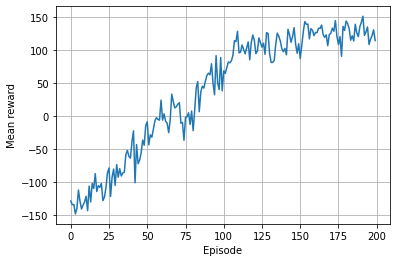

In [42]:
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()